### Import librairies 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

### Load images

In [31]:
content_path = r"C:\Users\User\Desktop\Internship\Neural Style Transfer\Content image.jpg"
style_path = r"C:\Users\User\Desktop\Internship\Neural Style Transfer\Style image.jpg"

### Load and process image

In [32]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [33]:
def deprocess(img):
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img
 
 
def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

### Load content image

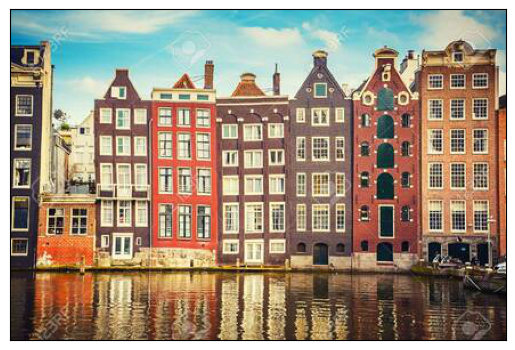

In [34]:
content_img = load_and_process_image(content_path)
display_image(content_img)

### Load style image

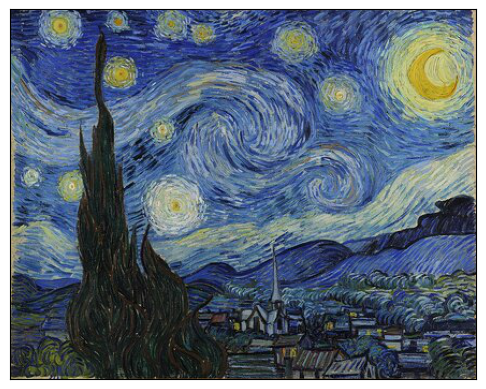

In [35]:
style_img = load_and_process_image(style_path)
display_image(style_img)

### Download the VGG model and initialise it

In [36]:
model = VGG19(
    include_top=False,
    weights='imagenet'
)

model.trainable = False
 
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Define content model

In [37]:
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

### Define style model

In [38]:
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

### Content loss

In [39]:
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)  # Add this line to compute a_G
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

### Gram matrix

In [40]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)
 
 
weight_of_layer = 1. / len(style_models)

### Style loss

In [41]:
def style_cost(style, generated):
    J_style = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        content_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += content_cost * weight_of_layer
 
    return J_style

### Training function

In [42]:
generated_images = []
 
 
def training_loop(content_path, style_path, iterations=100, a=10, b=1000):
    # load content and style images from their respective paths
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_cost = math.inf
    best_image = None
    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()
        with tf.GradientTape() as tape:
            J_content = content_loss(content, generated)  # Corrected line
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        end_time_cpu = time.process_time()
        end_time_wall = time.time()
        cpu_time = end_time_cpu - start_time_cpu
        wall_time = end_time_wall - start_time_wall

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
            int(cpu_time * 1e6),
            int((end_time_cpu - start_time_cpu) * 1e9),
            int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
        )

        print("Wall time: {:.2f} µs".format(wall_time * 1e6))
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())

    return best_image


In [43]:
final_img = training_loop(content_path, style_path)

CPU times: user 49281250 µs, sys: 49281250000 ns, total: 49281251 µs
Wall time: 16799635.17 µs
Iteration :0
Total Loss 1.055467e+12.
CPU times: user 46906250 µs, sys: 46906250000 ns, total: 46906251 µs
Wall time: 14843809.13 µs
Iteration :1
Total Loss 3.620463e+11.
CPU times: user 46421875 µs, sys: 46421875000 ns, total: 46421876 µs
Wall time: 14754926.44 µs
Iteration :2
Total Loss 1.724072e+11.
CPU times: user 44562500 µs, sys: 44562500000 ns, total: 44562501 µs
Wall time: 14619762.42 µs
Iteration :3
Total Loss 1.133689e+11.
CPU times: user 48343750 µs, sys: 48343750000 ns, total: 48343751 µs
Wall time: 14553546.67 µs
Iteration :4
Total Loss 9.215339e+10.
CPU times: user 44859375 µs, sys: 44859375000 ns, total: 44859376 µs
Wall time: 14404410.12 µs
Iteration :5
Total Loss 8.355068e+10.
CPU times: user 45500000 µs, sys: 45500000000 ns, total: 45500001 µs
Wall time: 14665507.79 µs
Iteration :6
Total Loss 7.676889e+10.
CPU times: user 47890625 µs, sys: 47890625000 ns, total: 47890626 µs


CPU times: user 54281250 µs, sys: 54281250000 ns, total: 54281251 µs
Wall time: 16867885.83 µs
Iteration :62
Total Loss 2.968400e+09.
CPU times: user 52125000 µs, sys: 52125000000 ns, total: 52125001 µs
Wall time: 18045029.16 µs
Iteration :63
Total Loss 2.898453e+09.
CPU times: user 48515625 µs, sys: 48515625000 ns, total: 48515626 µs
Wall time: 17309713.84 µs
Iteration :64
Total Loss 2.831907e+09.
CPU times: user 49296875 µs, sys: 49296875000 ns, total: 49296876 µs
Wall time: 16030363.32 µs
Iteration :65
Total Loss 2.768468e+09.
CPU times: user 49203125 µs, sys: 49203125000 ns, total: 49203126 µs
Wall time: 15811511.28 µs
Iteration :66
Total Loss 2.707914e+09.
CPU times: user 48625000 µs, sys: 48625000000 ns, total: 48625001 µs
Wall time: 16688416.00 µs
Iteration :67
Total Loss 2.650051e+09.
CPU times: user 48875000 µs, sys: 48875000000 ns, total: 48875001 µs
Wall time: 16999411.11 µs
Iteration :68
Total Loss 2.594690e+09.
CPU times: user 49140625 µs, sys: 49140625000 ns, total: 49140

### Display the last 10 intermediate results

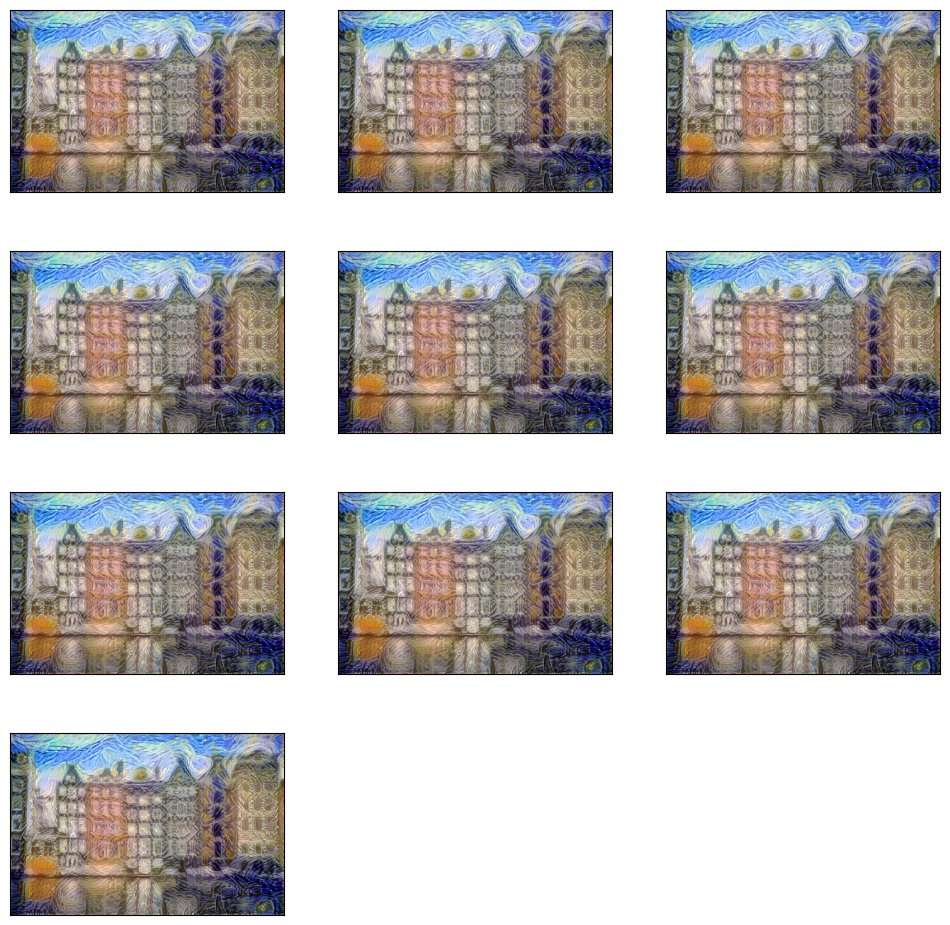

In [44]:
plt.figure(figsize=(12, 12))

for i in range(min(10, len(generated_images))):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[-10 + i])  
plt.show()

### Plot best result

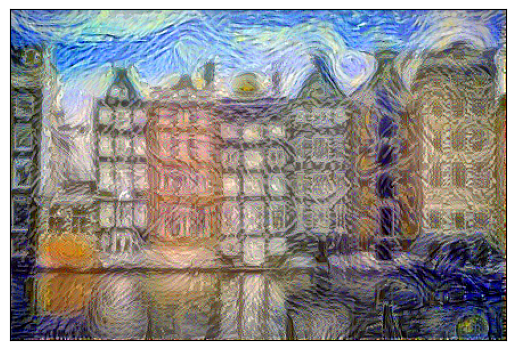

In [45]:
display_image(final_img)